In [1]:
import pandas as pd 
import numpy as np
import prepare , explore, modeling
#to see the whole review, display max column width
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
import seaborn as sns
import re
sns.set_palette("colorblind")
sns.set_style('darkgrid')
import nltk



from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

# Rate My Review
## An Analysis on Hotel reviews in Texas
#### Xavier Carter, September 2021

----

#### The Dataset
- Using Selinium, 13,800 reviews were gathered from various hotels across 4 major cities in Texas (Houston, Austin, Dallas, San Antonio)

#### Project Goals
- Analyze reviews to understand correlation to the review rating and the review. 
- Build a machine learning model to predict what rating a review should get.

#### Executive Summary
- Executive Summary here

----

## Acquire
- Utilizing Selinium (see acquire1.py and acquire2.py) , Gathering review information from TripAdvisor.com
- For sake of time, the max number of reviews looked at for each hotel was maxed to 35, as some hotels had hundreds of reviews

In [2]:
df = pd.read_csv('hotel_data.csv')

In [3]:
df.head(2)

hotel_name   hotel_city     date_of_stay  \
0  Drury Plaza Hotel San Antonio Riverwalk  San Antonio   September 2021   
1  Drury Plaza Hotel San Antonio Riverwalk  San Antonio   September 2020   

   review_rating  \
0              5   
1              5   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  review  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Joseph was so helpful and attentive! Awesome customer service. Made our trip more enjoyable! This will now be our go to hotel when we come to San Antonio. Everything about the hotel was nice and the staff was very friendly. Very pleased with the whole experience.  
1  We stayed one night at the Drury Plaza Riverwalk in mid-September. Sooo enjoyed our stay. Definitely our favorite hotel on the Riverwalk. We specifically stayed here for the rooms with the balconies overlooking the San Fernando Cathedral. I sat on that balcony all day long, reading and enjoying the view, even despite the day of rain! Love the separate bedroom! The afternoon happy hour could have easily sufficed for dinner had the allure of the Riverwalk restaurants not been there. The indoor pool/hot tub was nice, and the fitness center was perfectly equipped with great views while running the treadmill. The breakfast was hearty and very good quality...love that they have biscuits and gravy! Every employee we encountered was upbeat and kind and seemed to be interested in serving

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13801 entries, 0 to 13800
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   hotel_name     13801 non-null  object
 1   hotel_city     13801 non-null  object
 2   date_of_stay   13801 non-null  object
 3   review_rating  13801 non-null  int64 
 4   review         13801 non-null  object
dtypes: int64(1), object(4)
memory usage: 539.2+ KB


In [5]:
df.isna().sum()

hotel_name       0
hotel_city       0
date_of_stay     0
review_rating    0
review           0
dtype: int64

In [6]:
df.describe()

review_rating
count   13801.000000
mean        3.622564
std         1.559053
min         1.000000
25%         2.000000
50%         4.000000
75%         5.000000
max         5.000000

In [7]:
for i in df.columns:
    print(df[i].value_counts())
    print('---------------------------')

La Cantera Resort & Spa                            70
Fairmont Austin                                    70
Fairfield Inn & Suites Austin North/Parmer Lane    35
Eilan Hotel And Spa, Ascend Hotel Collection       35
Aloft Dallas Love Field                            35
                                                   ..
Palomino Motel & Trailer Park                       1
TownePlace Suites by Marriott Houston I-10 East     1
Ramada Limited Addison                              1
Kasa Dallas West End Apartments                     1
Hampton Inn & Suites Dallas I-30 Cockrell Hill      1
Name: hotel_name, Length: 548, dtype: int64
---------------------------
Austin         4033
San Antonio    3633
Houston        3574
Dallas         2561
Name: hotel_city, dtype: int64
---------------------------
 August 2021      1356
 July 2021        1215
 February 2020     696
 June 2021         696
 May 2021          695
                  ... 
 August 2013         1
 August 2007         1
 October 20

#### Acquire Findings 

#### TO-Do's:
1). The cap for reviews was 35, each review being unique, since value counts of 70 and 2 were seen, duplicates exist in the data. duplicates need to be removed.

2). Month and year can be in their own seperate columns.

3.) no null values or missing values. 

4.) Standardize english words using NLP processing, Standard cleaning using NLTK.

----

## Prepare
- In Preperation, we will
     * Drop Duplicates
     * Split month and year into seperate columns 
     * Drop date of stay column
     * Prep review content (Basic cleaning, tokenizing, lemmentizing, removing stop words, excluding common negative stop words)
     * Makeing columns for word and letter count
     * creating columns for negative , postive and neautral sentiment from cleaned version of the review (post clean, tokenize , lemmatized, and stop words removed, keeping popular negative stop words as negative stops words have the power to change the meaning of the review)
     * create bins for sentiment columns for exploration

In [8]:
df = prepare.prep_review_data(df)

In [9]:
df.head(3)

hotel_name   hotel_city  review_rating  \
0  Drury Plaza Hotel San Antonio Riverwalk  San Antonio              5   
1  Drury Plaza Hotel San Antonio Riverwalk  San Antonio              5   
2  Drury Plaza Hotel San Antonio Riverwalk  San Antonio              5   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  review  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Joseph was so helpful and attentive! Awesome customer service. Made our trip more enjoyable! This will now be our go to hotel when we come to San Antonio. Everything about the hotel was nice and the staff was very friendly. Very pleased with the whole experience.   
1  We stayed one night at the Drury Plaza Riverwalk in mid-September. Sooo enjoyed our stay. Definitely our favorite hotel on the Riverwalk. We specifically stayed here for the rooms with the balconies overlooking the San Fernando Cathedral. I sat on that balcony all day long, reading and enjoying the view, even despite the day of rain! Love the separate bedroom! The afternoon happy hour could have easily sufficed for dinner had the allure of the Riverwalk restaurants not been there. The indoor pool/hot tub was nice, and the fitness center was perfectly equipped with great views while running the treadmill. The breakfast was hearty and very good quality...love that they have biscuits and gravy! Every employee we encountered was upbeat and kind and seemed to be interested in serving   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              On a very busy weekend, I had the pleasure of experiencing, Excellent customer service and very friendly Felt I made the right choice staying here Johnny and ZOE made me feel special And they were busy   

  month_of_stay year_of_stay  \
0     September         2021   
1     September         2020   
2     September         2021   

                                                                                                                                                                                                                                                                                                                                                                                                                                     

----

## Outliers 
- Here , we'll take a look at possible anomolies
     * looking at positive sentiment reviews with low ratings
     * looking at negative sentiment reviews with high ratings

In [10]:
postive_when_neg  = (df.positive_sentiment  >= .450) & (df.review_rating == 1)
negative_when_pos = (df.negative_sentiment  >= .450) & (df.review_rating == 5)

In [11]:
df[postive_when_neg].sample(3)

hotel_name   hotel_city  review_rating  \
550   Hyatt Place San Antonio/Riverwalk  San Antonio              1   
8552           Hotel ZaZa Memorial City      Houston              1   
5125         Comfort Suites NW Lakeline       Austin              1   

                                                                                                                                                                                                                                                                                                          review  \
550                                                                                                   It was a short stay for us, but everything ran smoothly and efficient even though the hotel looked full. It was clean and staff appeared willing to help. Great place to stay. We will definitely go back.   
8552  I tried to book a birthday party at the hotel. The hotel party coordinator made written discriminatory comments to me and she refused to put the amount that I had agreed to pay for the party event in the party contract which resulted in me having to call my family and friends and cancel the party.   
5125                                                                    All around good place to stay whatever you reason for travel to Austin, easy access to major roads that take you all around town and back to your comfortable room. Nice breakfast and competent staff that is responsive to your needs.   

     month_of_stay year_of_stay  \
550           July         2021   
8552         March         2021   
5125         March         2019   

                                                                                                                                                                                     review_cleaned  \
550                                              short stay u everything ran smoothly efficient even though hotel looked full clean staff appeared willing help great place stay definitely go back   
8552  tried book birthday party hotel hotel party coordinator made written discriminatory comment refused put amount agreed pay party event party contract resulted call family friend cancel party   
5125                              around good place stay whatever reason travel austin easy access major road take around town back comfortable room nice breakfast competent staff responsive need   

      message_length  word_count  positive_sentiment  negative_sentiment  \
550              146          23               0.469               0.000   
8552             189          27               0.454               0.135   
5125             161          24               0.481               0.000   

      neatral_sentiment  
550               0.531  
8552              0.411  
5125              0.519

In [12]:
df[negative_when_pos]

hotel_name hotel_city  review_rating  \
13793  Econo Lodge Inn & Suites     Dallas              5   

                                                                                                                                       review  \
13793  Service of staff was a little bad and rude, In the lobby the didn't have the uniform. And the location is not good, is very dangerous.   

      month_of_stay year_of_stay  \
13793         March         2014   

                                                                      review_cleaned  \
13793  service staff little bad rude lobby didnt uniform location not good dangerous   

       message_length  word_count  positive_sentiment  negative_sentiment  \
13793              77          12               0.134               0.499   

       neatral_sentiment  
13793              0.367

#### Most of these may be miss clicked, as these people may wanted to rate higher or lower then their sentiment may suggest. so we will remove these from the dataframe as outliers so our model isnt trained in a way that might skew the results.

In [13]:
df = prepare.remove_outliers(df)

In [14]:
len(df)

13719

### Split Model 

In [15]:
train, validate, test = prepare.split_for_model(df,'review_rating')

(7682, 12),(3293, 12),(2744, 12)


## Explore - Distiributions, Length and Sentiment

### univariate 

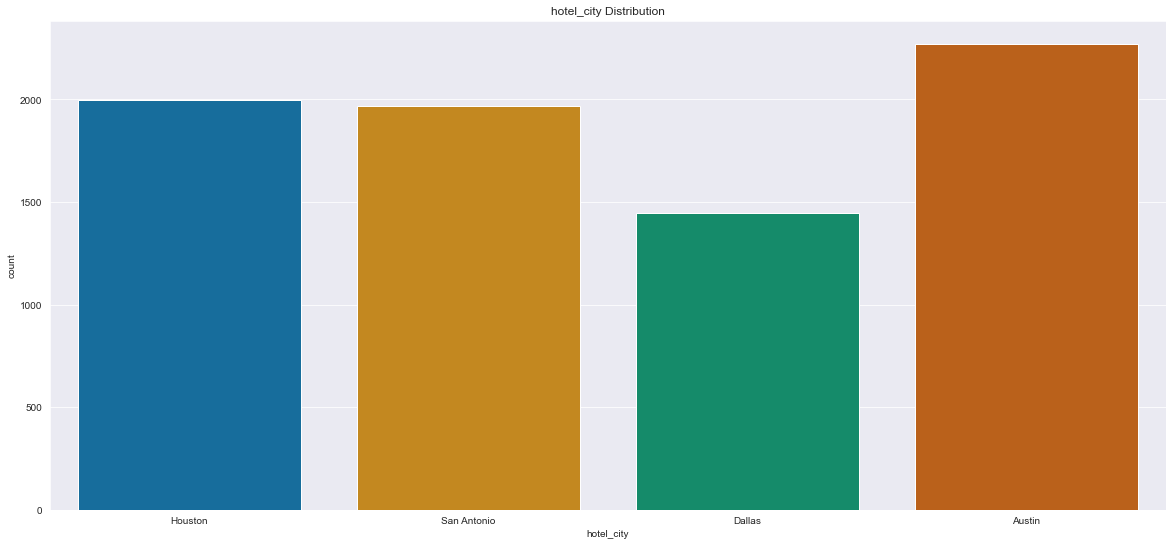

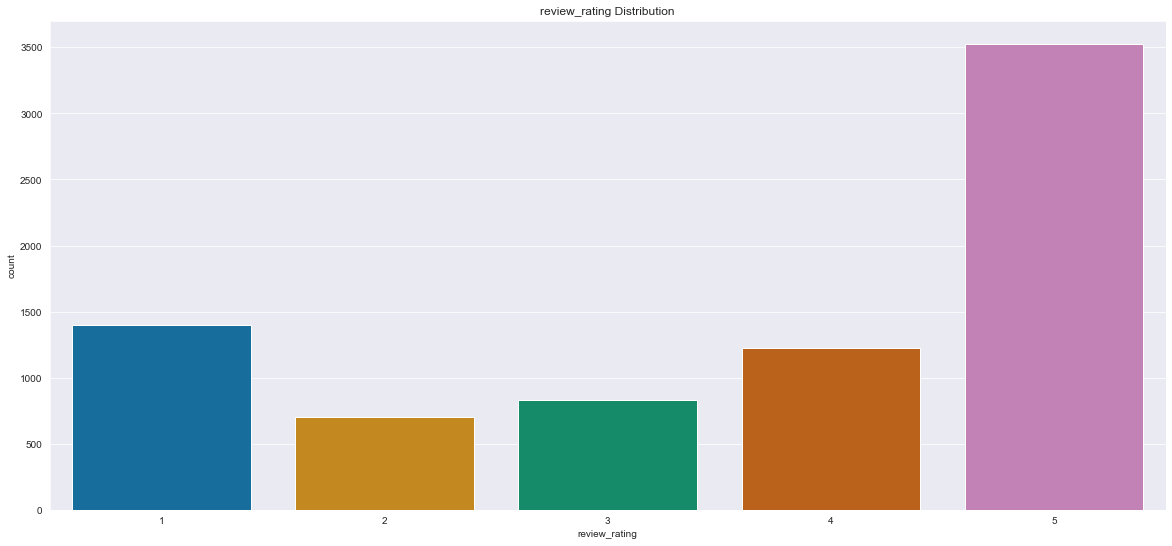

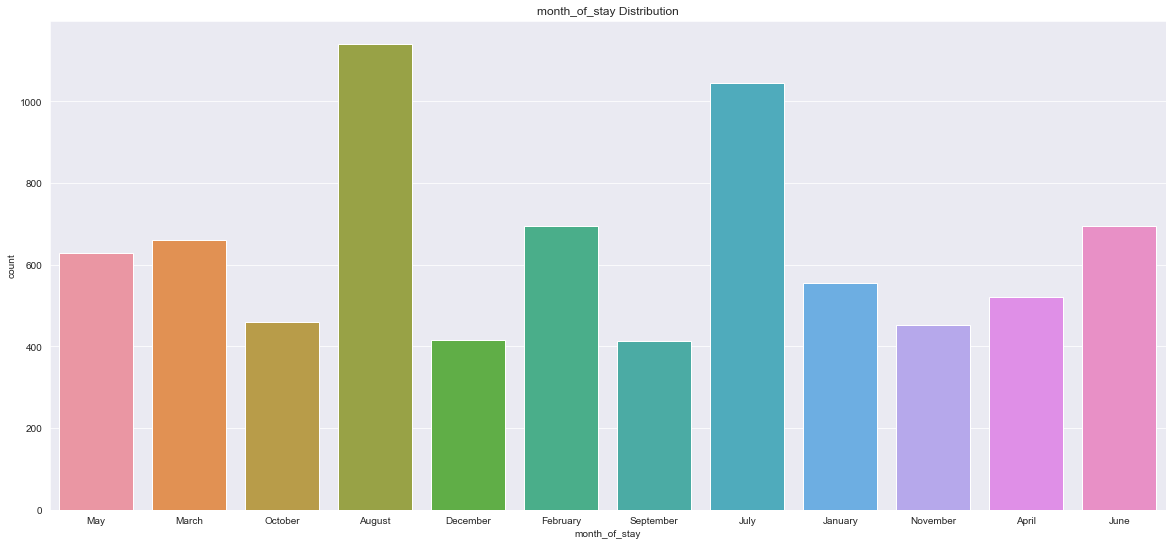

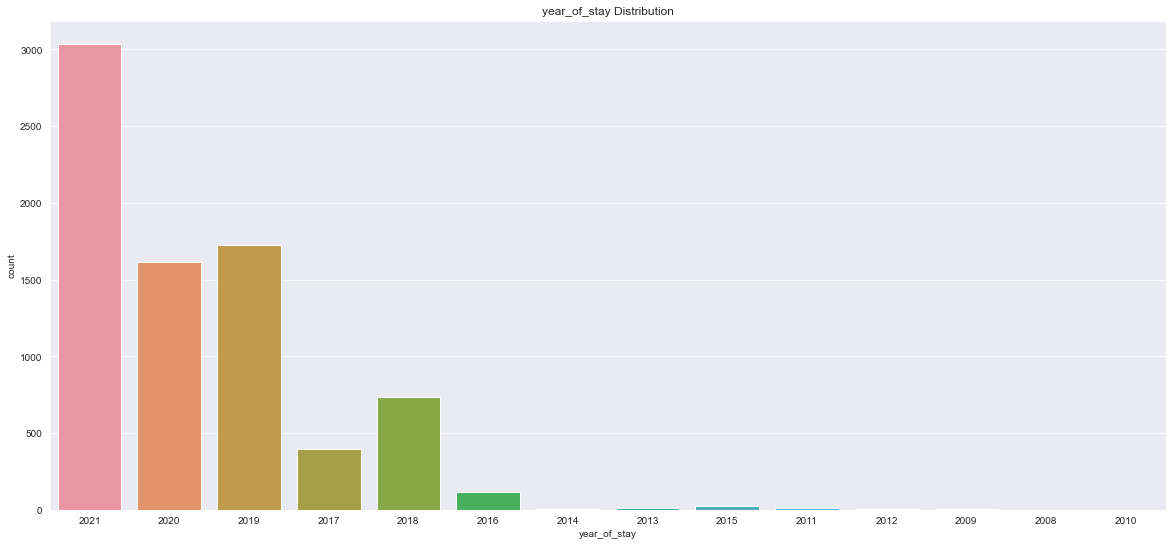

In [16]:
explore.get_distribution(train.drop(columns=['hotel_name','review', 'review_cleaned','positive_sentiment','negative_sentiment', 'neatral_sentiment','message_length', 'word_count']))

### Bivariate

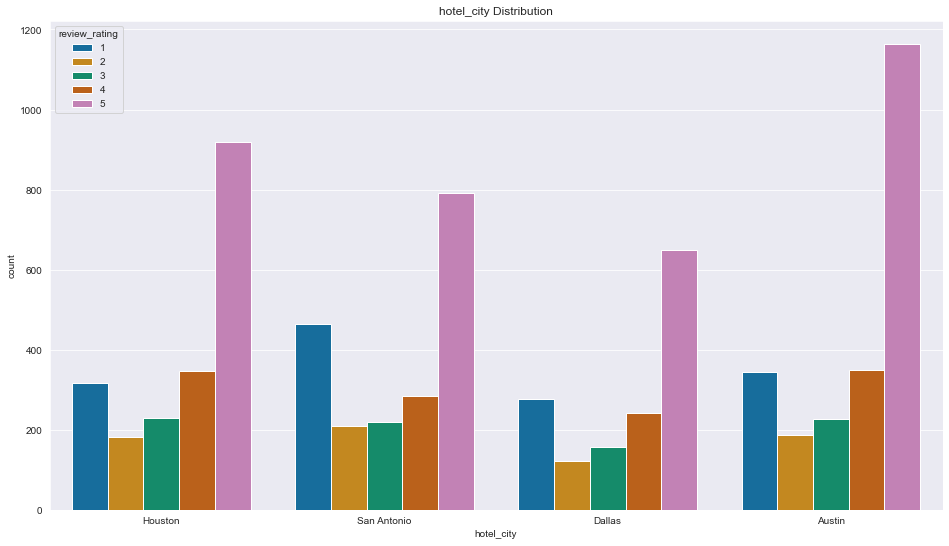

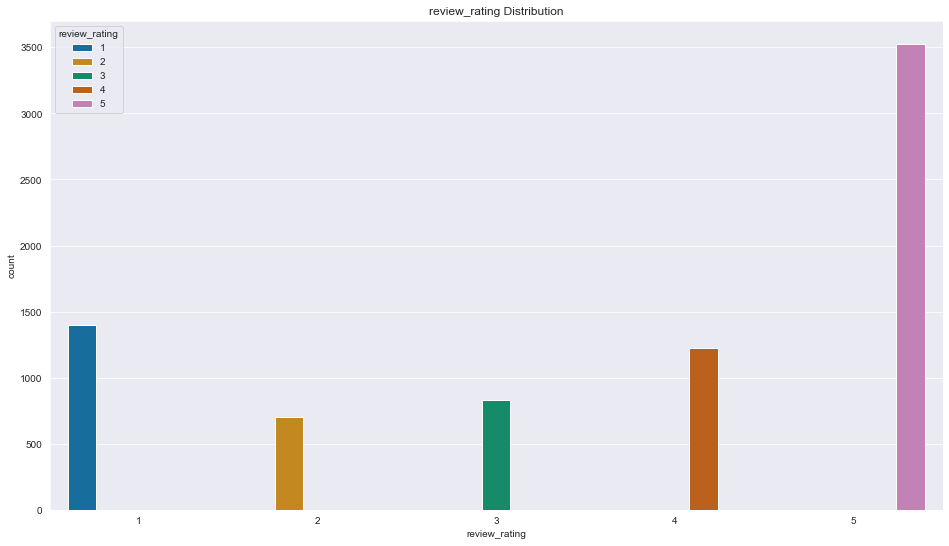

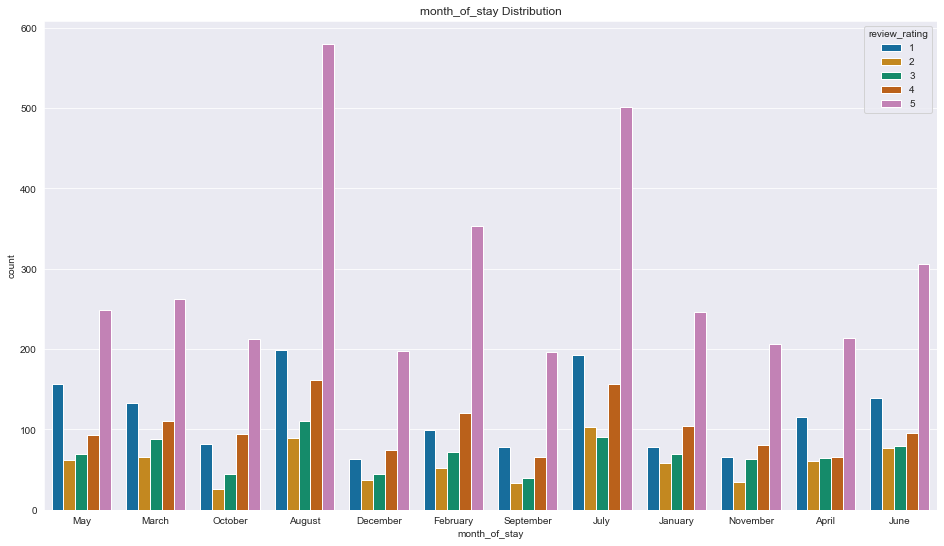

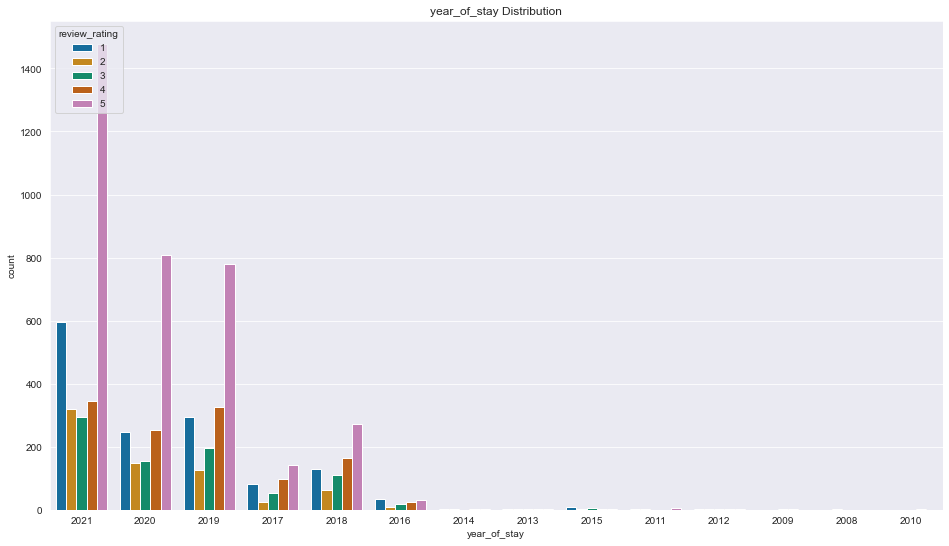

In [17]:
explore.compare_to_target(train.drop(columns=['hotel_name','review', 'review_cleaned','positive_sentiment','negative_sentiment', 'neatral_sentiment','word_count', 'message_length']), 'review_rating')

### Does word count and message length differ for different review ratings?

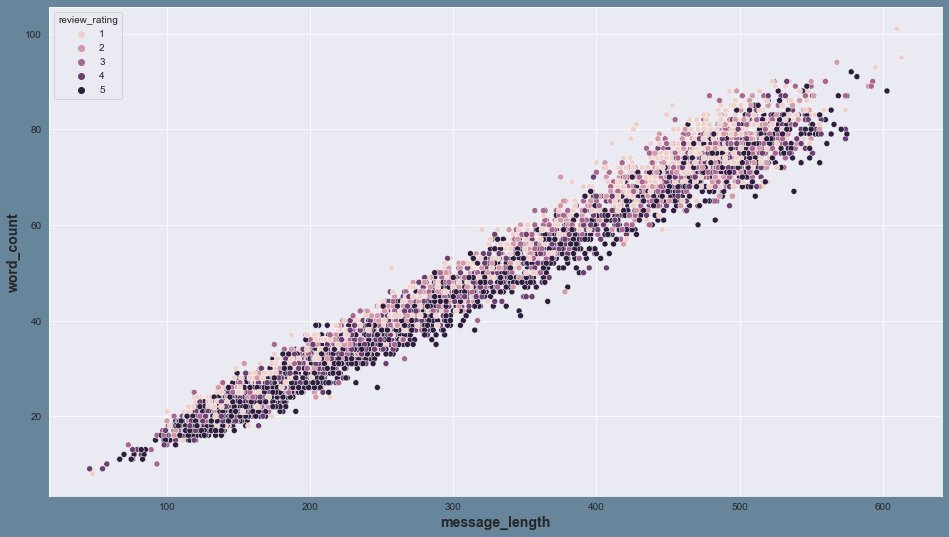

In [18]:
plt.figure(figsize=(16,9),facecolor='#67869b') 
sns.scatterplot(data = train, x = 'message_length', y ='word_count', hue='review_rating')
plt.xlabel('message_length',fontweight='bold', fontsize=14)
plt.ylabel('word_count',fontweight='bold', fontsize=14)
plt.show()

### Average Message length for each review score?

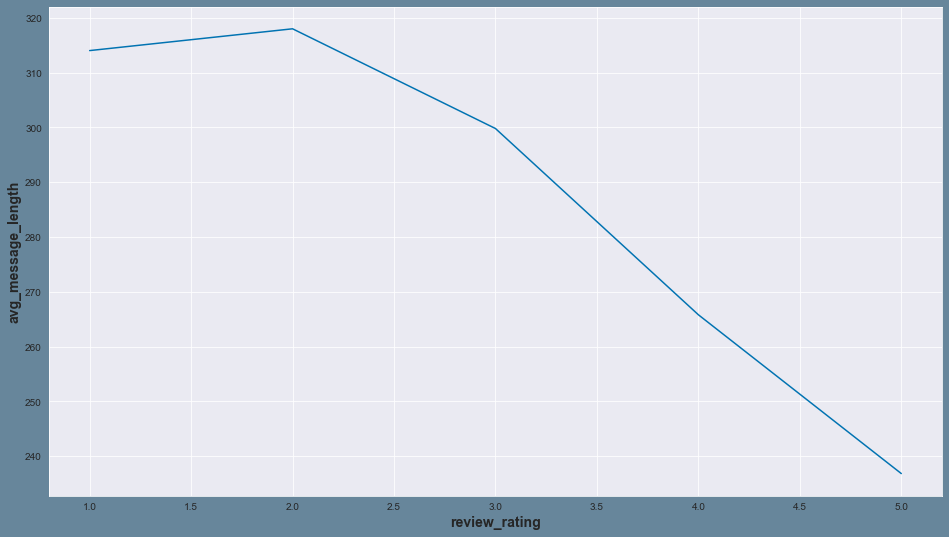

In [19]:
plt.figure(figsize=(16,9),facecolor='#67869b') 
group = train.groupby(['review_rating']).agg(avg_message_length =("message_length", 'mean'))
group = group.reset_index()
plt.xlabel('review_rating',fontweight='bold', fontsize=14)
plt.ylabel('avg_message_length',fontweight='bold', fontsize=14) 
sns.lineplot(data=group, x = 'review_rating', y = 'avg_message_length')
plt.show()

### Average Word Count for each review score?

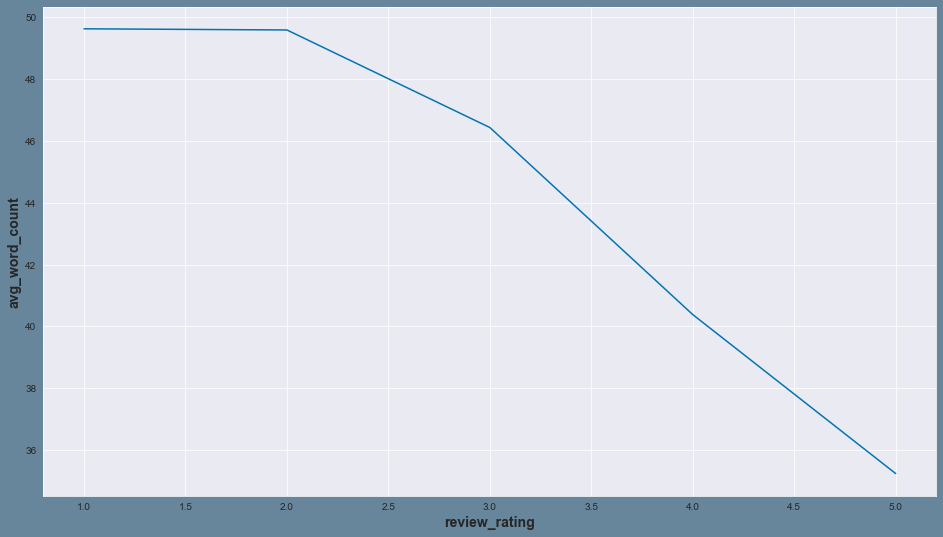

In [20]:
plt.figure(figsize=(16,9),facecolor='#67869b') 
group = train.groupby(['review_rating']).agg(avg_word_count =("word_count", 'mean'))
group = group.reset_index()
sns.lineplot(data=group, x = 'review_rating', y = 'avg_word_count')
plt.xlabel('review_rating',fontweight='bold', fontsize=14)
plt.ylabel('avg_word_count',fontweight='bold', fontsize=14) 
plt.show()

### Average rating for each city?

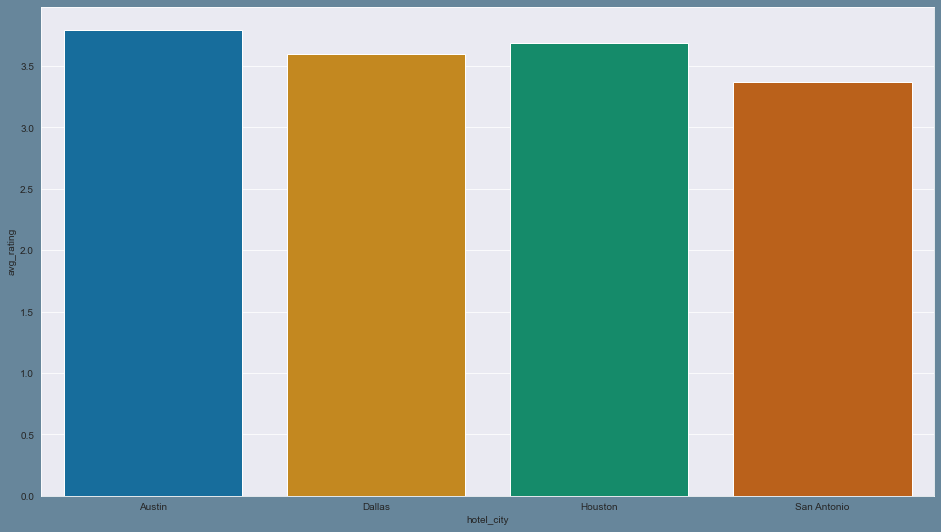

In [21]:
plt.figure(figsize=(16,9),facecolor='#67869b') 
group = train.groupby(['hotel_city']).agg(avg_rating =("review_rating", 'mean'))
group = group.reset_index()
sns.barplot(data=group, x = 'hotel_city', y = 'avg_rating')
plt.show()

### Average Rating for each month? 

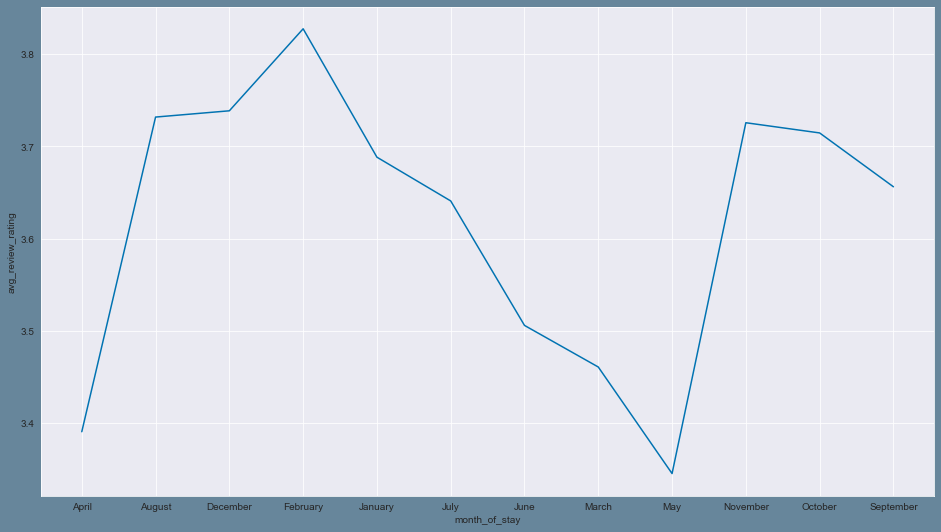

In [22]:
plt.figure(figsize=(16,9),facecolor='#67869b') 
group = train.groupby(['month_of_stay']).agg(avg_review_rating =("review_rating", 'mean'))
group = group.reset_index()
sns.lineplot(data=group, x = 'month_of_stay', y = 'avg_review_rating')
plt.show()

### Average Sentiment for each review rating?

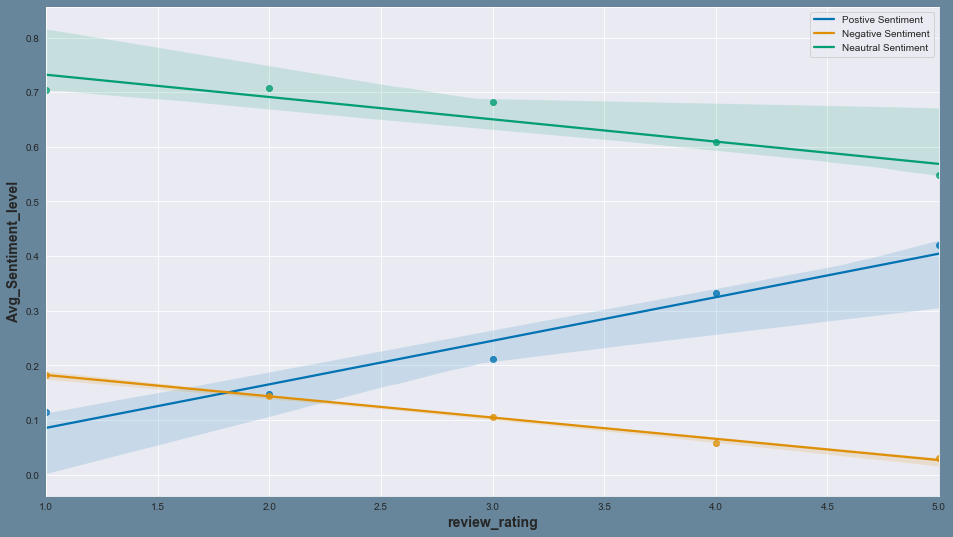

In [23]:
plt.figure(figsize=(16,9),facecolor='#67869b') 
group = train.groupby(['review_rating']).agg(avg_pos_sent =("positive_sentiment", 'mean'), avg_neg_sent =('negative_sentiment', 'mean'), avg_neu_sent =('neatral_sentiment', 'mean'))
group = group.reset_index()
sns.regplot(data=group, x = 'review_rating', y = 'avg_pos_sent')
sns.regplot(data=group, x = 'review_rating', y = 'avg_neg_sent')
sns.regplot(data=group, x = 'review_rating', y = 'avg_neu_sent')
plt.xlabel('review_rating',fontweight='bold', fontsize=14)
plt.ylabel('Avg_Sentiment_level',fontweight='bold', fontsize=14) 
plt.legend(labels=['Postive Sentiment','Negative Sentiment','Neautral Sentiment'])
plt.show()

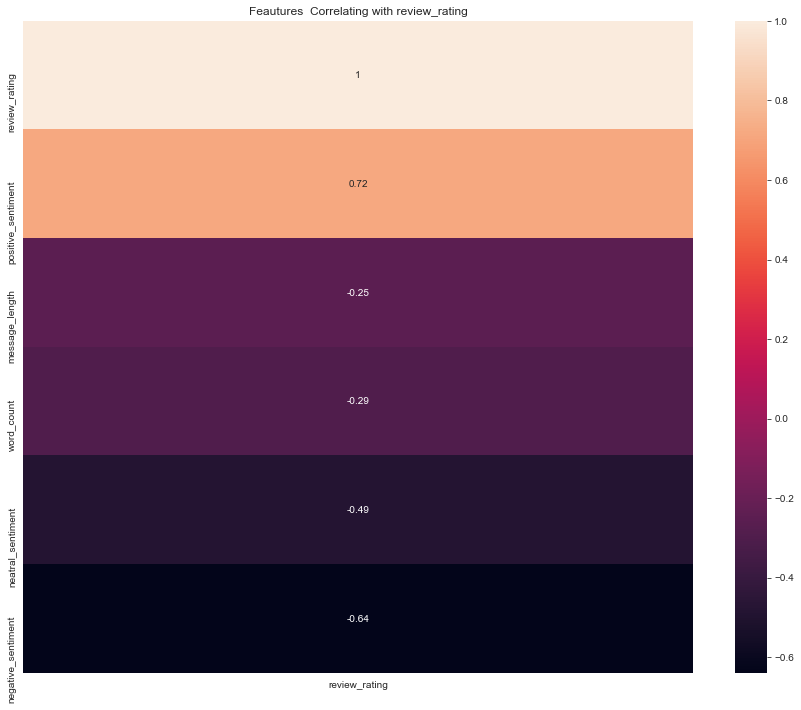

<AxesSubplot:title={'center':'Feautures  Correlating with review_rating'}>

In [24]:
explore.get_heatmap(train, 'review_rating')

#### Takeaways 

- Univariate
    * When selecting reviews at random, theyre were more 5 star reviews, followed by one star reviews. Hinting may tend to be obligated to write a review  when they either really loved their stay , or despised it.
    * When collecting reviews at random, many of the hotel stays took place in Auguest, followed by July and May. Mid-summer and spring break time seem to be the most popular times to visit hotels, while the least month of stay was september and november.
- Bivariate, in relation to review rating
    * Hotel Ratings for each city were still distributed in order as follows: 5,1,4,3,2 
    * The distrubution differs over the various months 
- Multivariate
    * Word count and message length decrease on average as the review gets better. suggesting when bad reviews have more words on average.
    * Austin and Houston have the best reviews on average, while San Antonio had the worst reviews on average
    * In terms of sentiment, Negative sentiment decreases as review ratings get higher, Positive sentiment increases as reviews get higher, Neatural sentiment is higher in negative reviews then positive sentiment.
    

## Explore - Word Analysis 

In [25]:
#Split words into strings 

In [26]:
one_read = ' '.join(train[train.review_rating == 1].review_cleaned)
two_read = ' '.join(train[train.review_rating == 2].review_cleaned)
three_read = ' '.join(train[train.review_rating == 3].review_cleaned)
four_read = ' '.join(train[train.review_rating == 4].review_cleaned)
five_read = ' '.join(train[train.review_rating == 5].review_cleaned)
all_read = ' '.join(train.review_cleaned)

In [27]:
#creating word frequencies
one_freq = pd.Series(one_read.split()).value_counts()
two_freq = pd.Series(two_read.split()).value_counts()
three_freq= pd.Series(three_read.split()).value_counts()
four_freq= pd.Series(four_read.split()).value_counts()
five_freq = pd.Series(five_read.split()).value_counts()
all_freq = pd.Series(all_read.split()).value_counts()

In [28]:
#create word list
one_star_words = re.sub(r'[^\w\s]', '', one_read).split()
two_star_words = re.sub(r'[^\w\s]', '', two_read).split()
three_star_words = re.sub(r'[^\w\s]', '', three_read).split()
four_star_words = re.sub(r'[^\w\s]', '', four_read).split()
five_star_words = re.sub(r'[^\w\s]', '', five_read).split()
all_words = re.sub(r'[^\w\s]', '', all_read).split()

In [29]:
#Creating word counts table
word_table = (pd.concat([one_freq, two_freq, three_freq, four_freq, five_freq,  all_freq], axis=1, sort=True)
                .fillna(0)
                .apply(lambda s: s.astype(int)))
#naming the columns
word_table.columns = ['one', 'two', 'three', 'four', 'five', 'All']

In [30]:
def show_distributions(word_table, orderby=None):
    plt.rc('figure', figsize=(16,9))
    (word_table
 .assign(one = word_table[orderby]  )
 .sort_values(orderby)
 [[orderby]]
 .tail(20)
 .sort_values(orderby)
 .plot.barh(stacked=True))
    

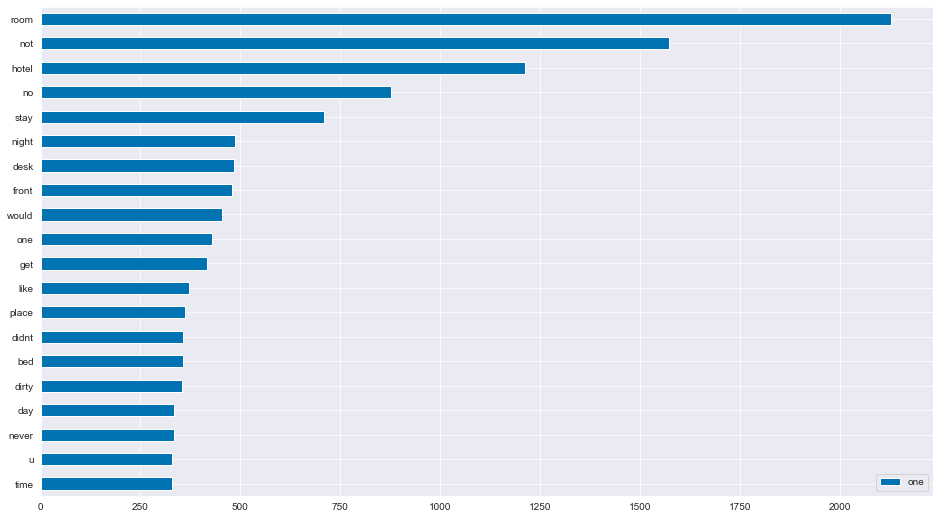

In [31]:
show_distributions(word_table, 'one')

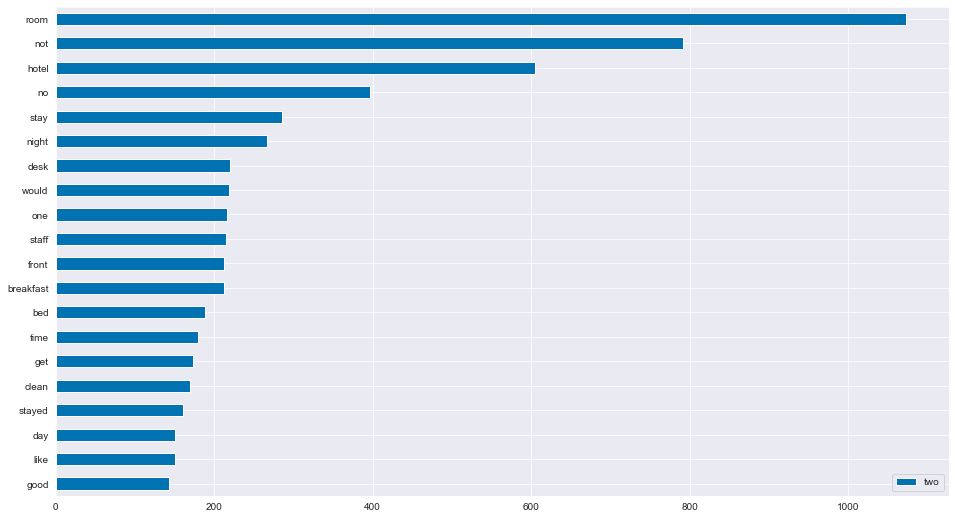

In [32]:
show_distributions(word_table, 'two')

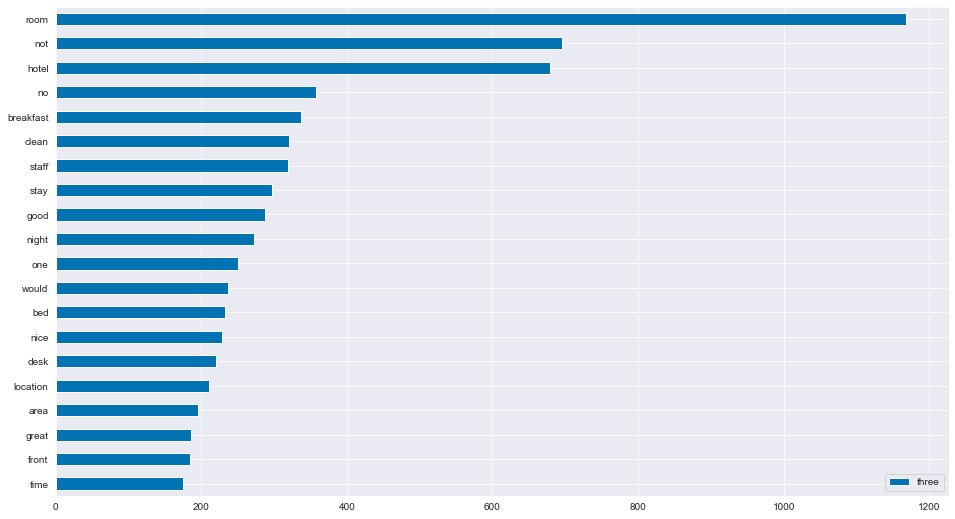

In [33]:
show_distributions(word_table, 'three')

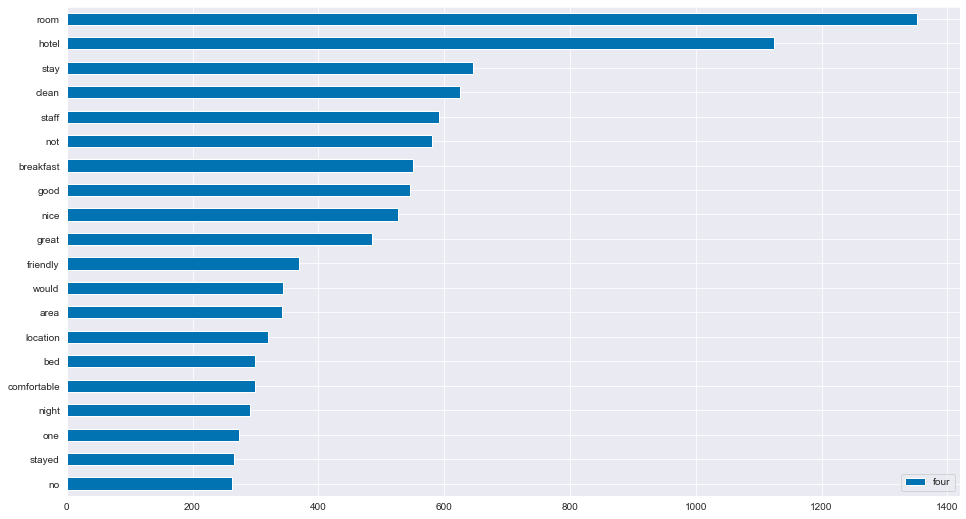

In [34]:
show_distributions(word_table, 'four')

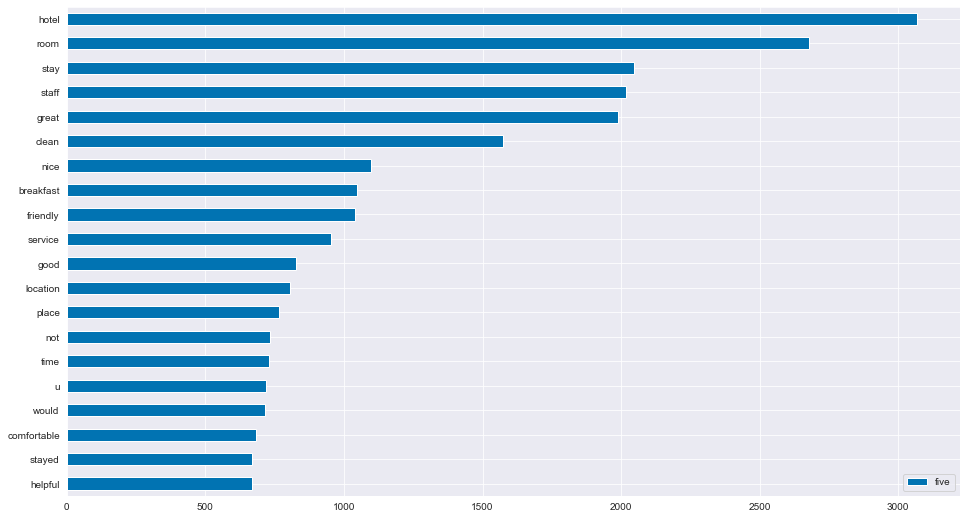

In [35]:
show_distributions(word_table, 'five')

In [36]:
from wordcloud import WordCloud
#function to create word clouds
def word_cloud(word_string, name):
    img = WordCloud(background_color='white', width=800, height=600).generate(word_string)
    print('-------------------')
    print(f'{name}')
    print('-------------------')
    plt.imshow(img)
    plt.axis('off')


def df_to_wordcloud(df, star = None):
    if star: 
        df = df[df.review_rating == star]
    else:
        star = 'all_words'
    to_list = ''
    for readme in df.review_cleaned:
        to_list += readme
    word_cloud(to_list,star)
    
    
def bigrams_wordclouds(thelist):
    data = {k[0] + ' ' + k[1]: v for k, v in thelist.to_dict().items()}
    img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
    plt.figure(figsize=(16,9))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
def trigrams_wordclouds(thelist):
    data = {k[0] + ' ' + k[1] + ' '+ k[2]: v for k, v in thelist.to_dict().items()}
    img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
    plt.figure(figsize=(16,9))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

-------------------
1
-------------------


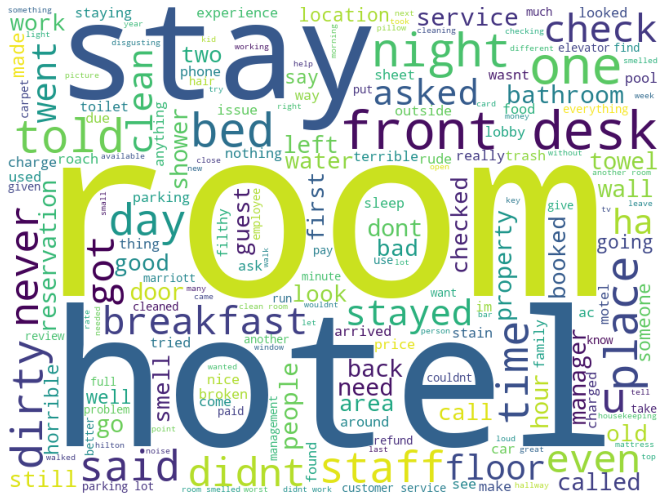

In [37]:
df_to_wordcloud(train, 1)

-------------------
2
-------------------


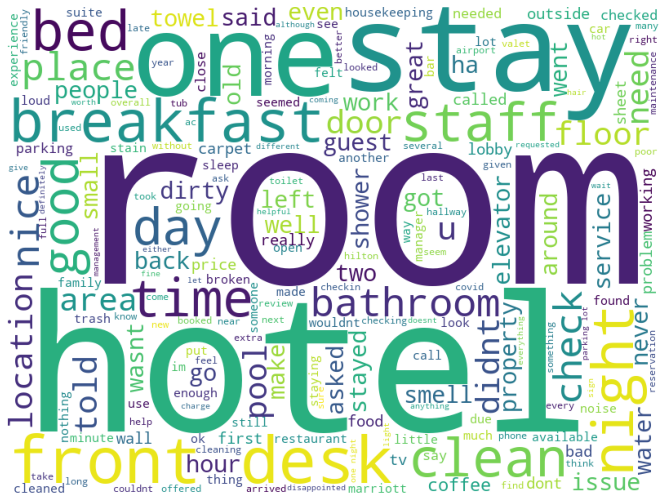

In [38]:
df_to_wordcloud(train, 2)

-------------------
3
-------------------


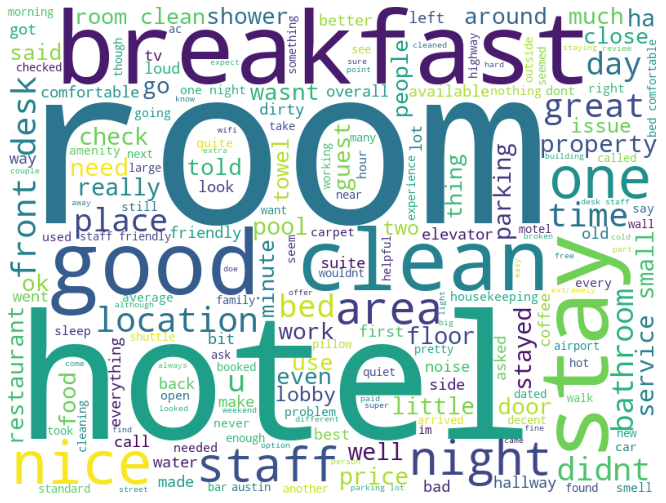

In [39]:
df_to_wordcloud(train, 3)

-------------------
4
-------------------


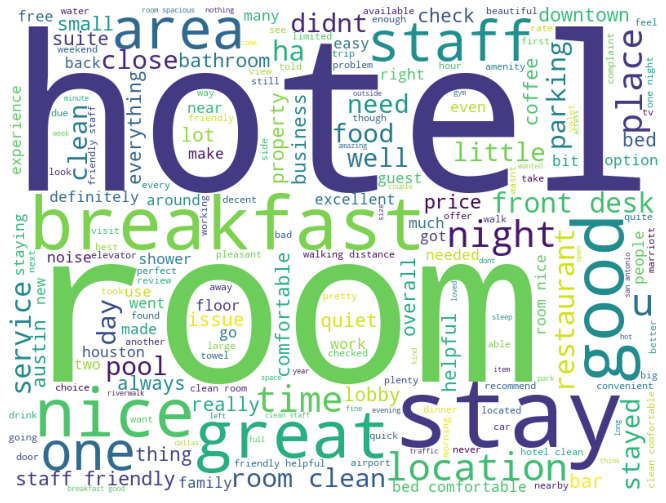

In [40]:
df_to_wordcloud(train, 4)

-------------------
5
-------------------


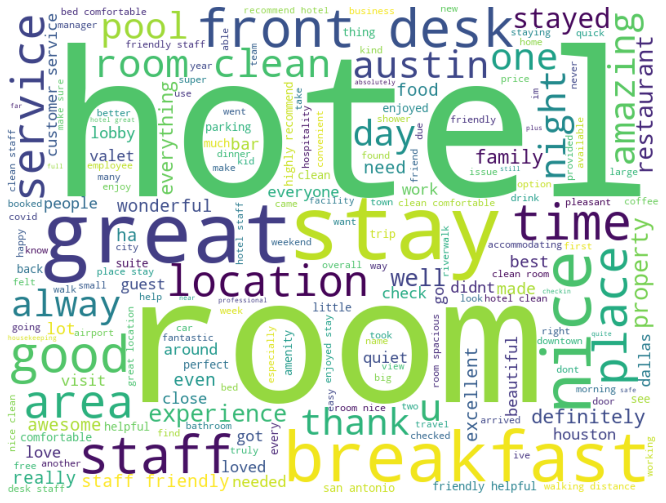

In [41]:
df_to_wordcloud(train, 5)

In [42]:
#bigrams
#bigrams for each review type
bigrams_one = pd.Series(nltk.ngrams(one_read.split(), 2)).value_counts()
bigrams_two = pd.Series(nltk.ngrams(two_read.split(), 2)).value_counts()
bigrams_three = pd.Series(nltk.ngrams(three_read.split(), 2)).value_counts()
bigrams_four = pd.Series(nltk.ngrams(four_read.split(), 2)).value_counts()
bigrams_five = pd.Series(nltk.ngrams(five_read.split(), 2)).value_counts()

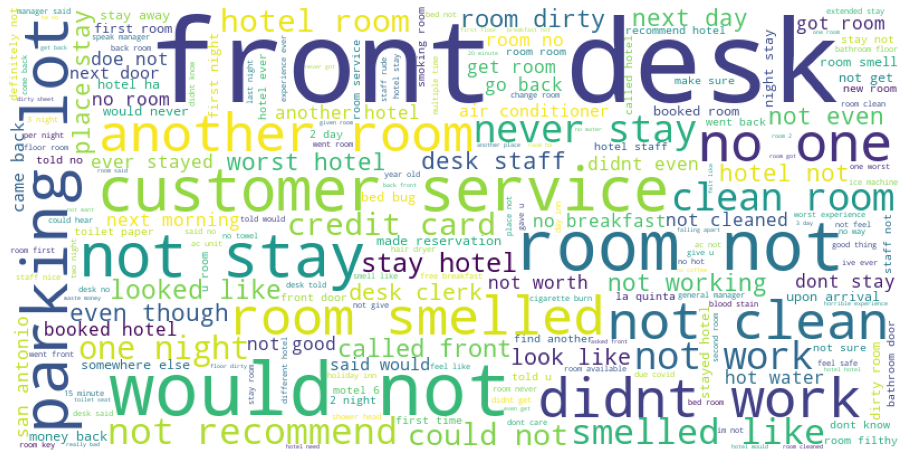

In [43]:
bigrams_wordclouds(bigrams_one)

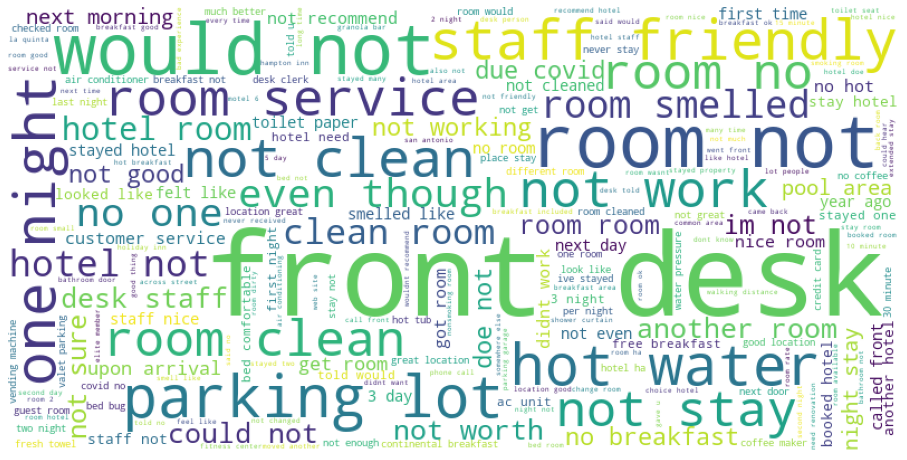

In [44]:
bigrams_wordclouds(bigrams_two)

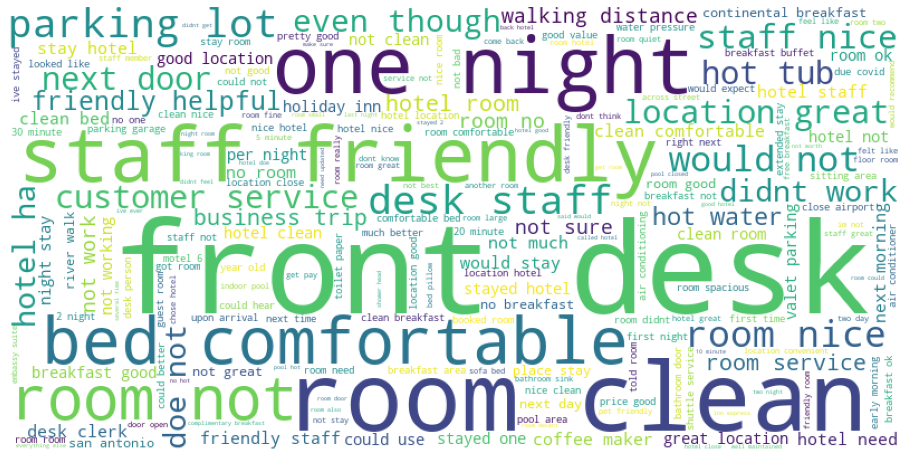

In [45]:
bigrams_wordclouds(bigrams_three)

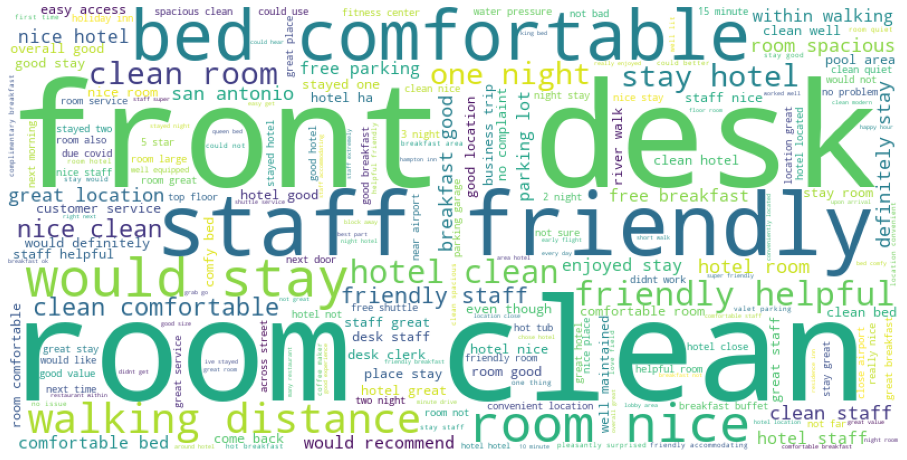

In [46]:
bigrams_wordclouds(bigrams_four)

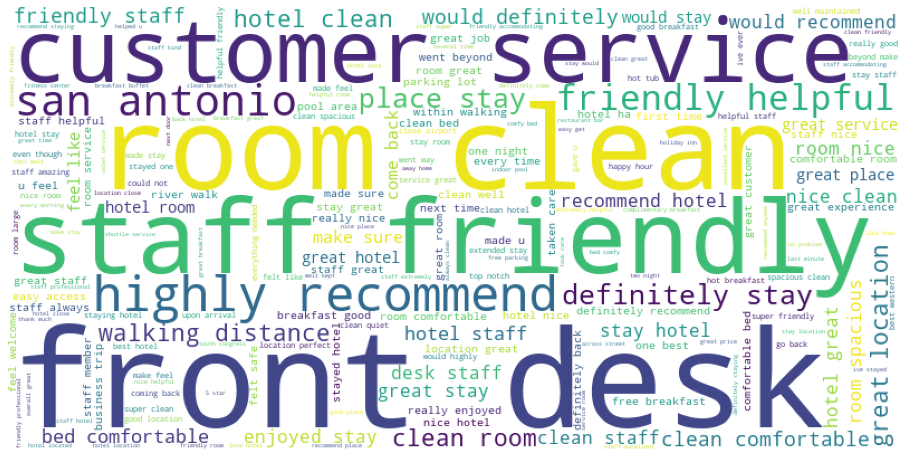

In [47]:
bigrams_wordclouds(bigrams_five)

In [48]:
#trigrams
#trigrams for each review type
trigrams_one = pd.Series(nltk.ngrams(one_read.split(), 3)).value_counts()
trigrams_two = pd.Series(nltk.ngrams(two_read.split(), 3)).value_counts()
trigrams_three = pd.Series(nltk.ngrams(three_read.split(), 3)).value_counts()
trigrams_four = pd.Series(nltk.ngrams(four_read.split(), 3)).value_counts()
trigrams_five = pd.Series(nltk.ngrams(five_read.split(), 3)).value_counts()

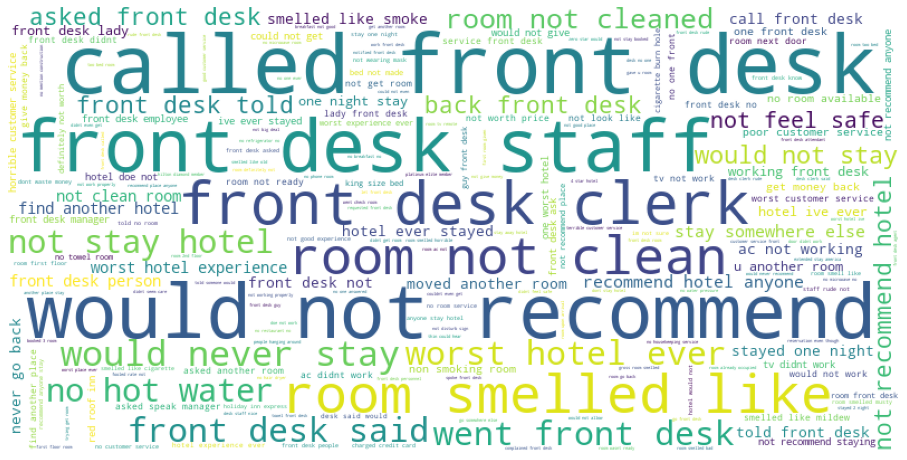

In [49]:
trigrams_wordclouds(trigrams_one)

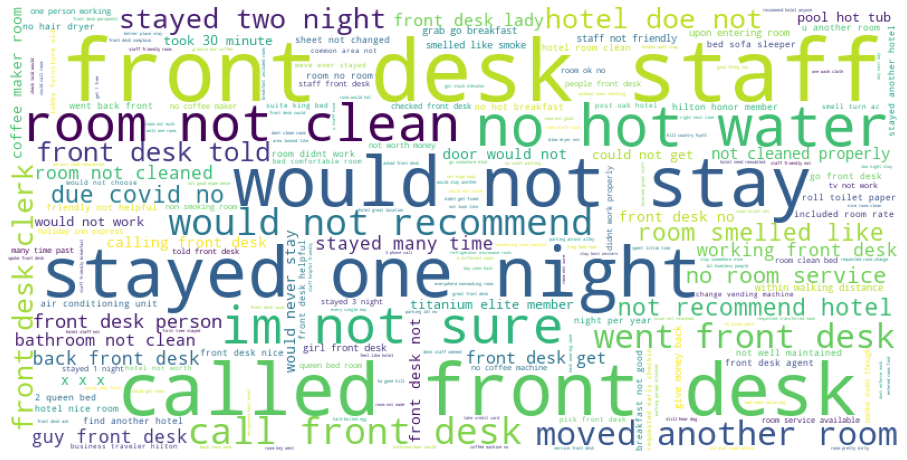

In [50]:
trigrams_wordclouds(trigrams_two)

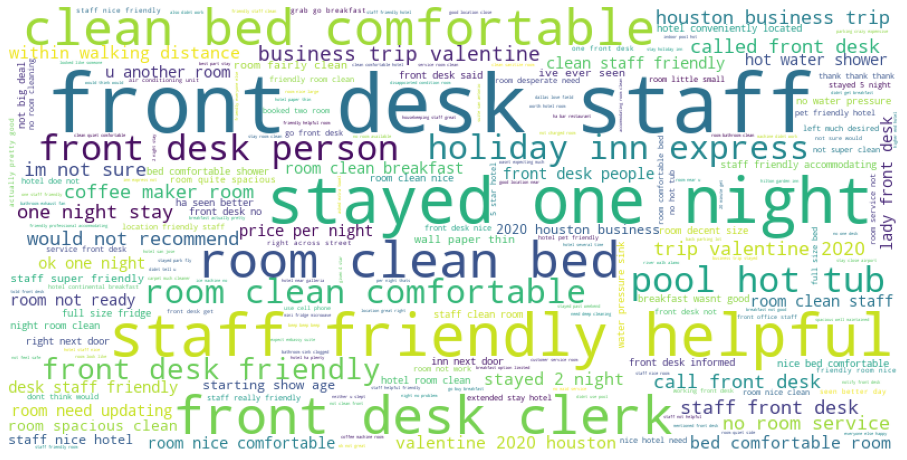

In [51]:
trigrams_wordclouds(trigrams_three)

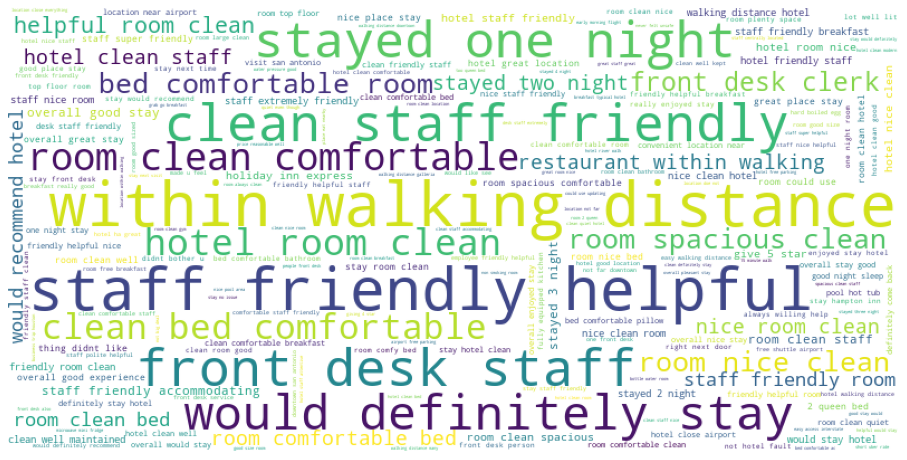

In [52]:
trigrams_wordclouds(trigrams_four)

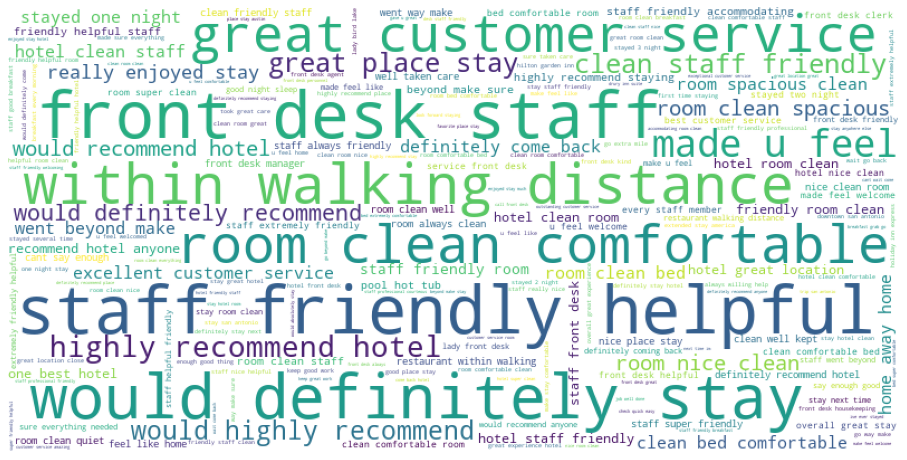

In [53]:
trigrams_wordclouds(trigrams_five)

## Takeaways

In [431]:
#remove top 3 most common words that are not negative (room, hotel)
top = all_freq.head(3).index.to_list()

# Statistical Testing

# Modeling 

In [469]:
#modeling for words
tfidf = TfidfVectorizer(ngram_range=(1,4))
X = tfidfs = tfidf.fit_transform(df.review_cleaned)
y = df.review_rating

In [470]:
df.columns

Index(['hotel_name', 'hotel_city', 'review_rating', 'review', 'month_of_stay',
       'year_of_stay', 'review_cleaned', 'message_length', 'word_count',
       'positive_sentiment', 'negative_sentiment', 'neatral_sentiment'],
      dtype='object')

In [472]:
#modeling for sentiment
X2 = df[['message_length','word_count', 'positive_sentiment', 'negative_sentiment', 'neatral_sentiment']]

In [473]:
X_train, X_validate, y_train, y_validate, X_test, y_test = modeling.xy_split(X, y)

In [474]:
X_train2,X_validate2, y_train2, y_validate2, X_test2, y_test2 = modeling.xy_split(X2,y)

In [475]:
modeling.get_baseline(train)

45.90000%


In [476]:
tree = DecisionTreeClassifier(max_depth=6)
modeling.train_validate_results(tree, X_train, y_train, X_validate, y_validate, details=True)

Train model Accuracy: 58.47436 %  | Validate model accuracy: 55.75463 % 
Train model Recall: 38.50563 %    | Validate model Recall: 35.14181 %
Train model Precision: 51.60692 % | Validate model Precision: 34.41843 %
------------------------------------------------------------------------
---------- More Details ------------
-----Train Classification report----
                     1           2           3            4            5  \
precision     0.496430    0.666667    0.327402     0.441558     0.648289   
recall        0.744468    0.034335    0.110312     0.139116     0.897050   
f1-score      0.595660    0.065306    0.165022     0.211574     0.752647   
support    1401.000000  699.000000  834.000000  1222.000000  3526.000000   

           accuracy    macro avg  weighted avg  
precision  0.584744     0.516069      0.554543  
recall     0.584744     0.385056      0.584744  
f1-score   0.584744     0.358042      0.511608  
support    0.584744  7682.000000   7682.000000  
------Valid

In [506]:
rf = RandomForestClassifier(max_depth=8)
modeling.train_validate_results(rf, X_train, y_train, X_validate, y_validate, details=True)

Train model Accuracy: 45.89951 %  | Validate model accuracy: 45.91558 % 
Train model Recall: 20.00000 %    | Validate model Recall: 20.00000 %
Train model Precision: 9.17990 % | Validate model Precision: 9.18312 %
------------------------------------------------------------------------
---------- More Details ------------
-----Train Classification report----
                1      2      3       4            5  accuracy    macro avg  \
precision     0.0    0.0    0.0     0.0     0.458995  0.458995     0.091799   
recall        0.0    0.0    0.0     0.0     1.000000  0.458995     0.200000   
f1-score      0.0    0.0    0.0     0.0     0.629193  0.458995     0.125839   
support    1401.0  699.0  834.0  1222.0  3526.000000  0.458995  7682.000000   

           weighted avg  
precision      0.210676  
recall         0.458995  
f1-score       0.288797  
support     7682.000000  
------Validate Classification report-----
               1      2      3      4            5  accuracy    macro a

In [512]:
rf = RandomForestClassifier(max_depth=6, )
modeling.train_validate_results(rf, X_train2, y_train2, X_validate2, y_validate2, details=True)

Train model Accuracy: 62.28847 %  | Validate model accuracy: 59.67203 % 
Train model Recall: 41.43283 %    | Validate model Recall: 38.03739 %
Train model Precision: 58.68778 % | Validate model Precision: 34.01234 %
------------------------------------------------------------------------
---------- More Details ------------
-----Train Classification report----
                     1           2           3            4            5  \
precision     0.528746    0.729730    0.345411     0.640449     0.690054   
recall        0.866524    0.038627    0.171463     0.046645     0.948383   
f1-score      0.656749    0.073370    0.229167     0.086957     0.798853   
support    1401.000000  699.000000  834.000000  1222.000000  3526.000000   

           accuracy    macro avg  weighted avg  
precision  0.622885     0.586878      0.618938  
recall     0.622885     0.414328      0.622885  
f1-score   0.622885     0.369019      0.531832  
support    0.622885  7682.000000   7682.000000  
------Valid